# **[Exoplanet Hunting in Deep Space](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data)**

## **LSTM-based model** that applieas a **sliding window** approach
### Sotir Xhixho

## **Workflow:**

###**1. Data Preprocessing & Balancing:**

- Loads the dataset and merges train and test data.
- Standardizes flux values using **StandardScaler**.
- Uses **SMOTE** to balance the dataset and address class imbalance.
- Splits the data into training **(80%)** and validation **(20%)** sets.

###**2. Feature Engineering:**

- Applies a **sliding window** approach to extract overlapping segments from time-series flux data.

###**3. Model Building & Hyperparameter Tuning:**

- Defines an **LSTM-based** deep learning model with **tunable hyperparameters** (number of LSTM units, dropout rate, learning rate).
- Uses Keras Tuner to optimize hyperparameters via Random Search.

###**4. Model Training & Evaluation:**

- Trains the best model with **early stopping** and **learning rate reductio**n.
- Evaluates performance using accuracy, loss curves, and class weights to handle imbalance.
- Detects overfitting by comparing training and validation accuracy.

###**5. Performance Metrics & Visualizations:**

- **Confusion Matrix** to show classification performance.
- Classification Report (Precision, Recall, F1-score).
- **ROC-AUC Curve** to measure model discrimination.

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 14.4 MB/s eta 0:00:00


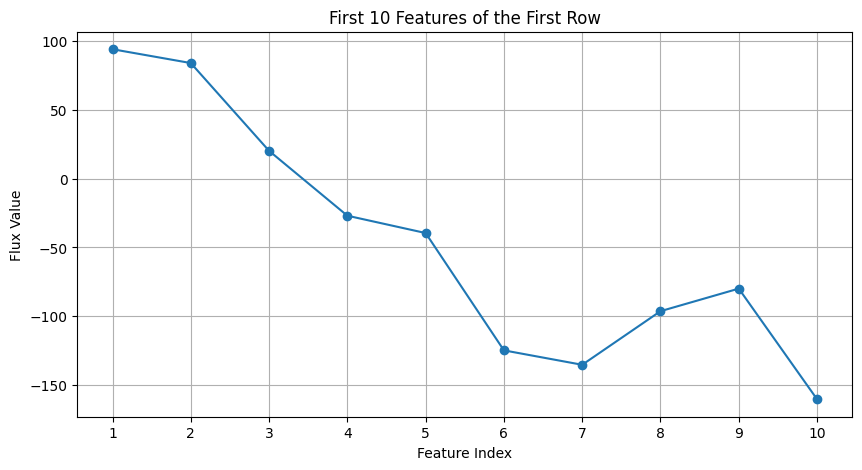

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/content/exoTrain.csv"
df = pd.read_csv(file_path)

# Extract the first row (excluding the label column)
first_row = df.iloc[0, 1:11]

# Plot the first 10 features
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), first_row.values, marker='o', linestyle='-')
plt.xlabel("Feature Index")
plt.ylabel("Flux Value")
plt.title("First 10 Features of the First Row")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

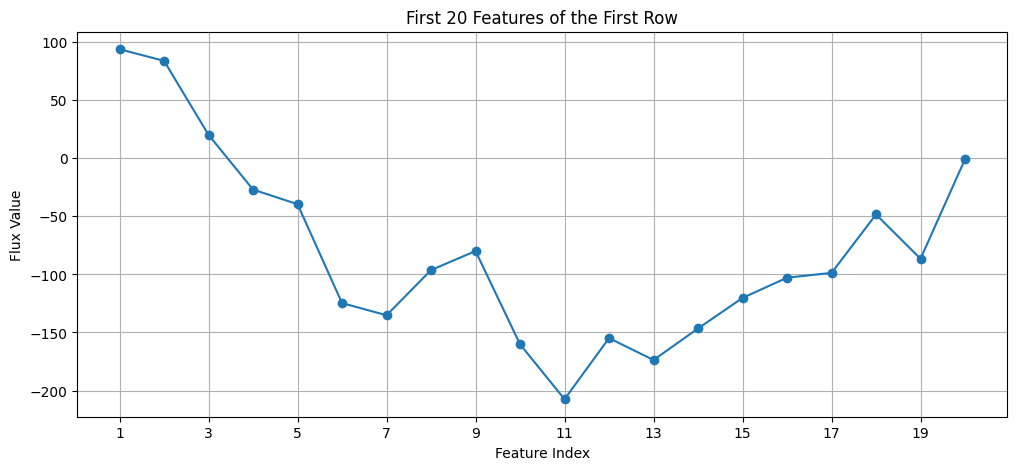

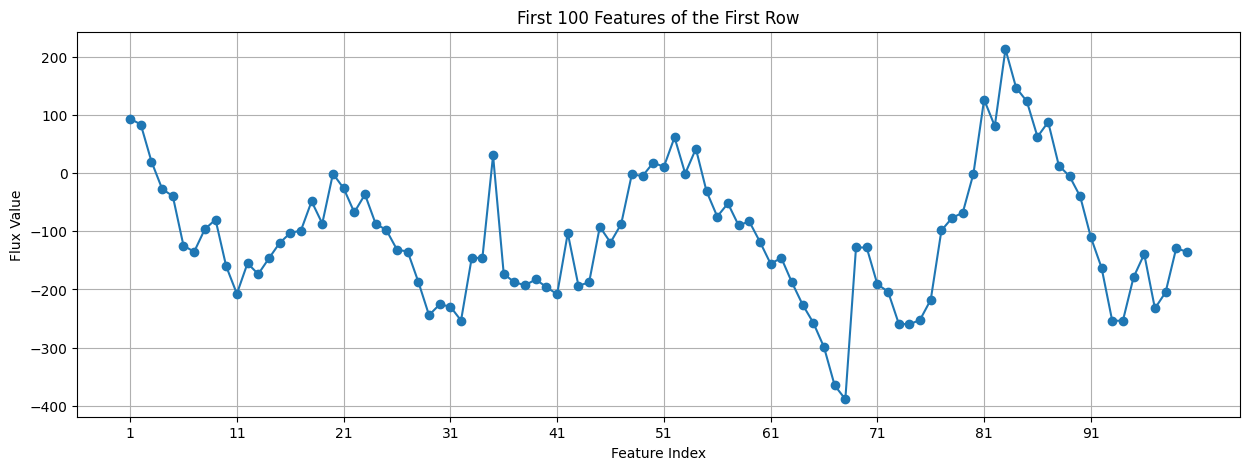

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/content/exoTrain.csv"
df = pd.read_csv(file_path)

# Extract the first row (excluding the label column)
first_row_20 = df.iloc[0, 1:21]
first_row_100 = df.iloc[0, 1:101]

# Plot first 20 features
plt.figure(figsize=(12, 5))
plt.plot(range(1, 21), first_row_20.values, marker='o', linestyle='-')
plt.xlabel("Feature Index")
plt.ylabel("Flux Value")
plt.title("First 20 Features of the First Row")
plt.xticks(range(1, 21, 2))
plt.grid(True)
plt.show()

# Plot first 100 features
plt.figure(figsize=(15, 5))
plt.plot(range(1, 101), first_row_100.values, marker='o', linestyle='-')
plt.xlabel("Feature Index")
plt.ylabel("Flux Value")
plt.title("First 100 Features of the First Row")
plt.xticks(range(1, 101, 10))
plt.grid(True)
plt.show()

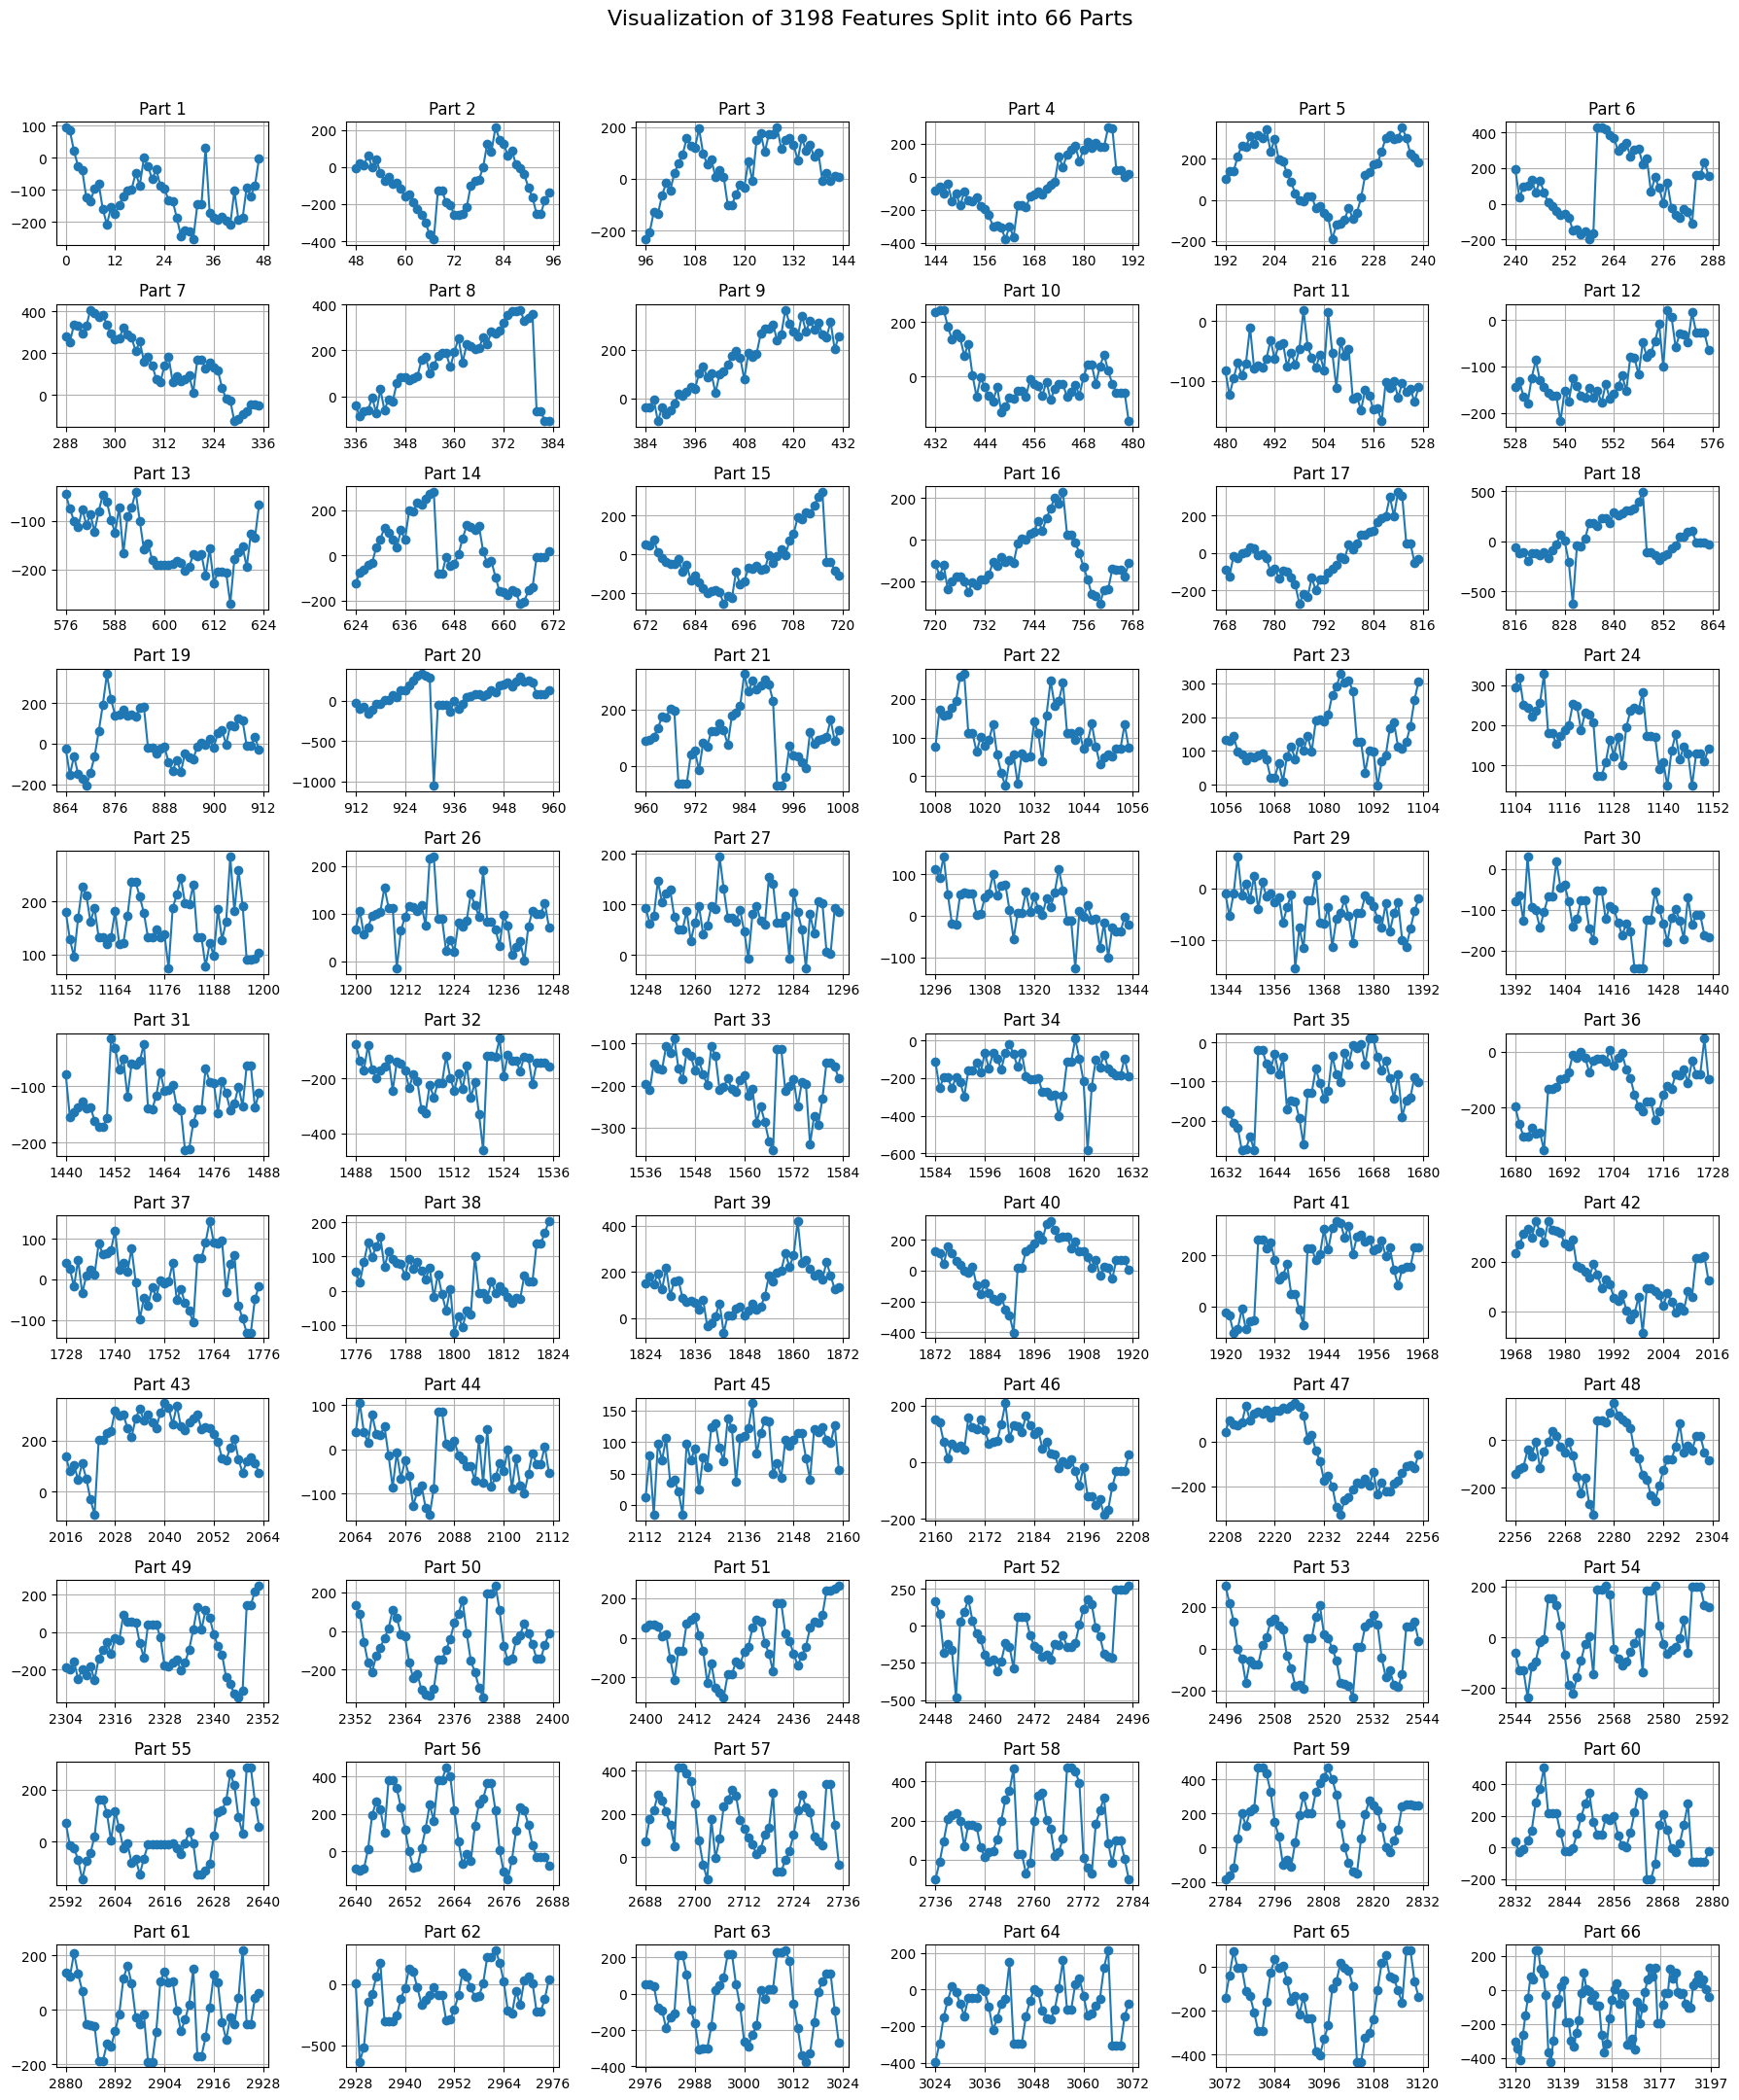

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = "/content/exoTrain.csv"
df = pd.read_csv(file_path)

# Extract the first row (excluding the label column)
features = df.iloc[0, 1:].values

# Split into 66 equal parts
num_splits = 66
split_size = len(features) // num_splits

# Create subplots
fig, axes = plt.subplots(nrows=11, ncols=6, figsize=(18, 22))
fig.suptitle("Visualization of 3198 Features Split into 66 Parts", fontsize=16)

# Plot each part in a separate subplot
for i, ax in enumerate(axes.flat):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < num_splits - 1 else len(features)

    ax.plot(range(start_idx, end_idx), features[start_idx:end_idx], marker='o', linestyle='-')
    ax.set_title(f"Part {i+1}")
    ax.set_xticks(np.linspace(start_idx, end_idx, num=5, dtype=int))
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

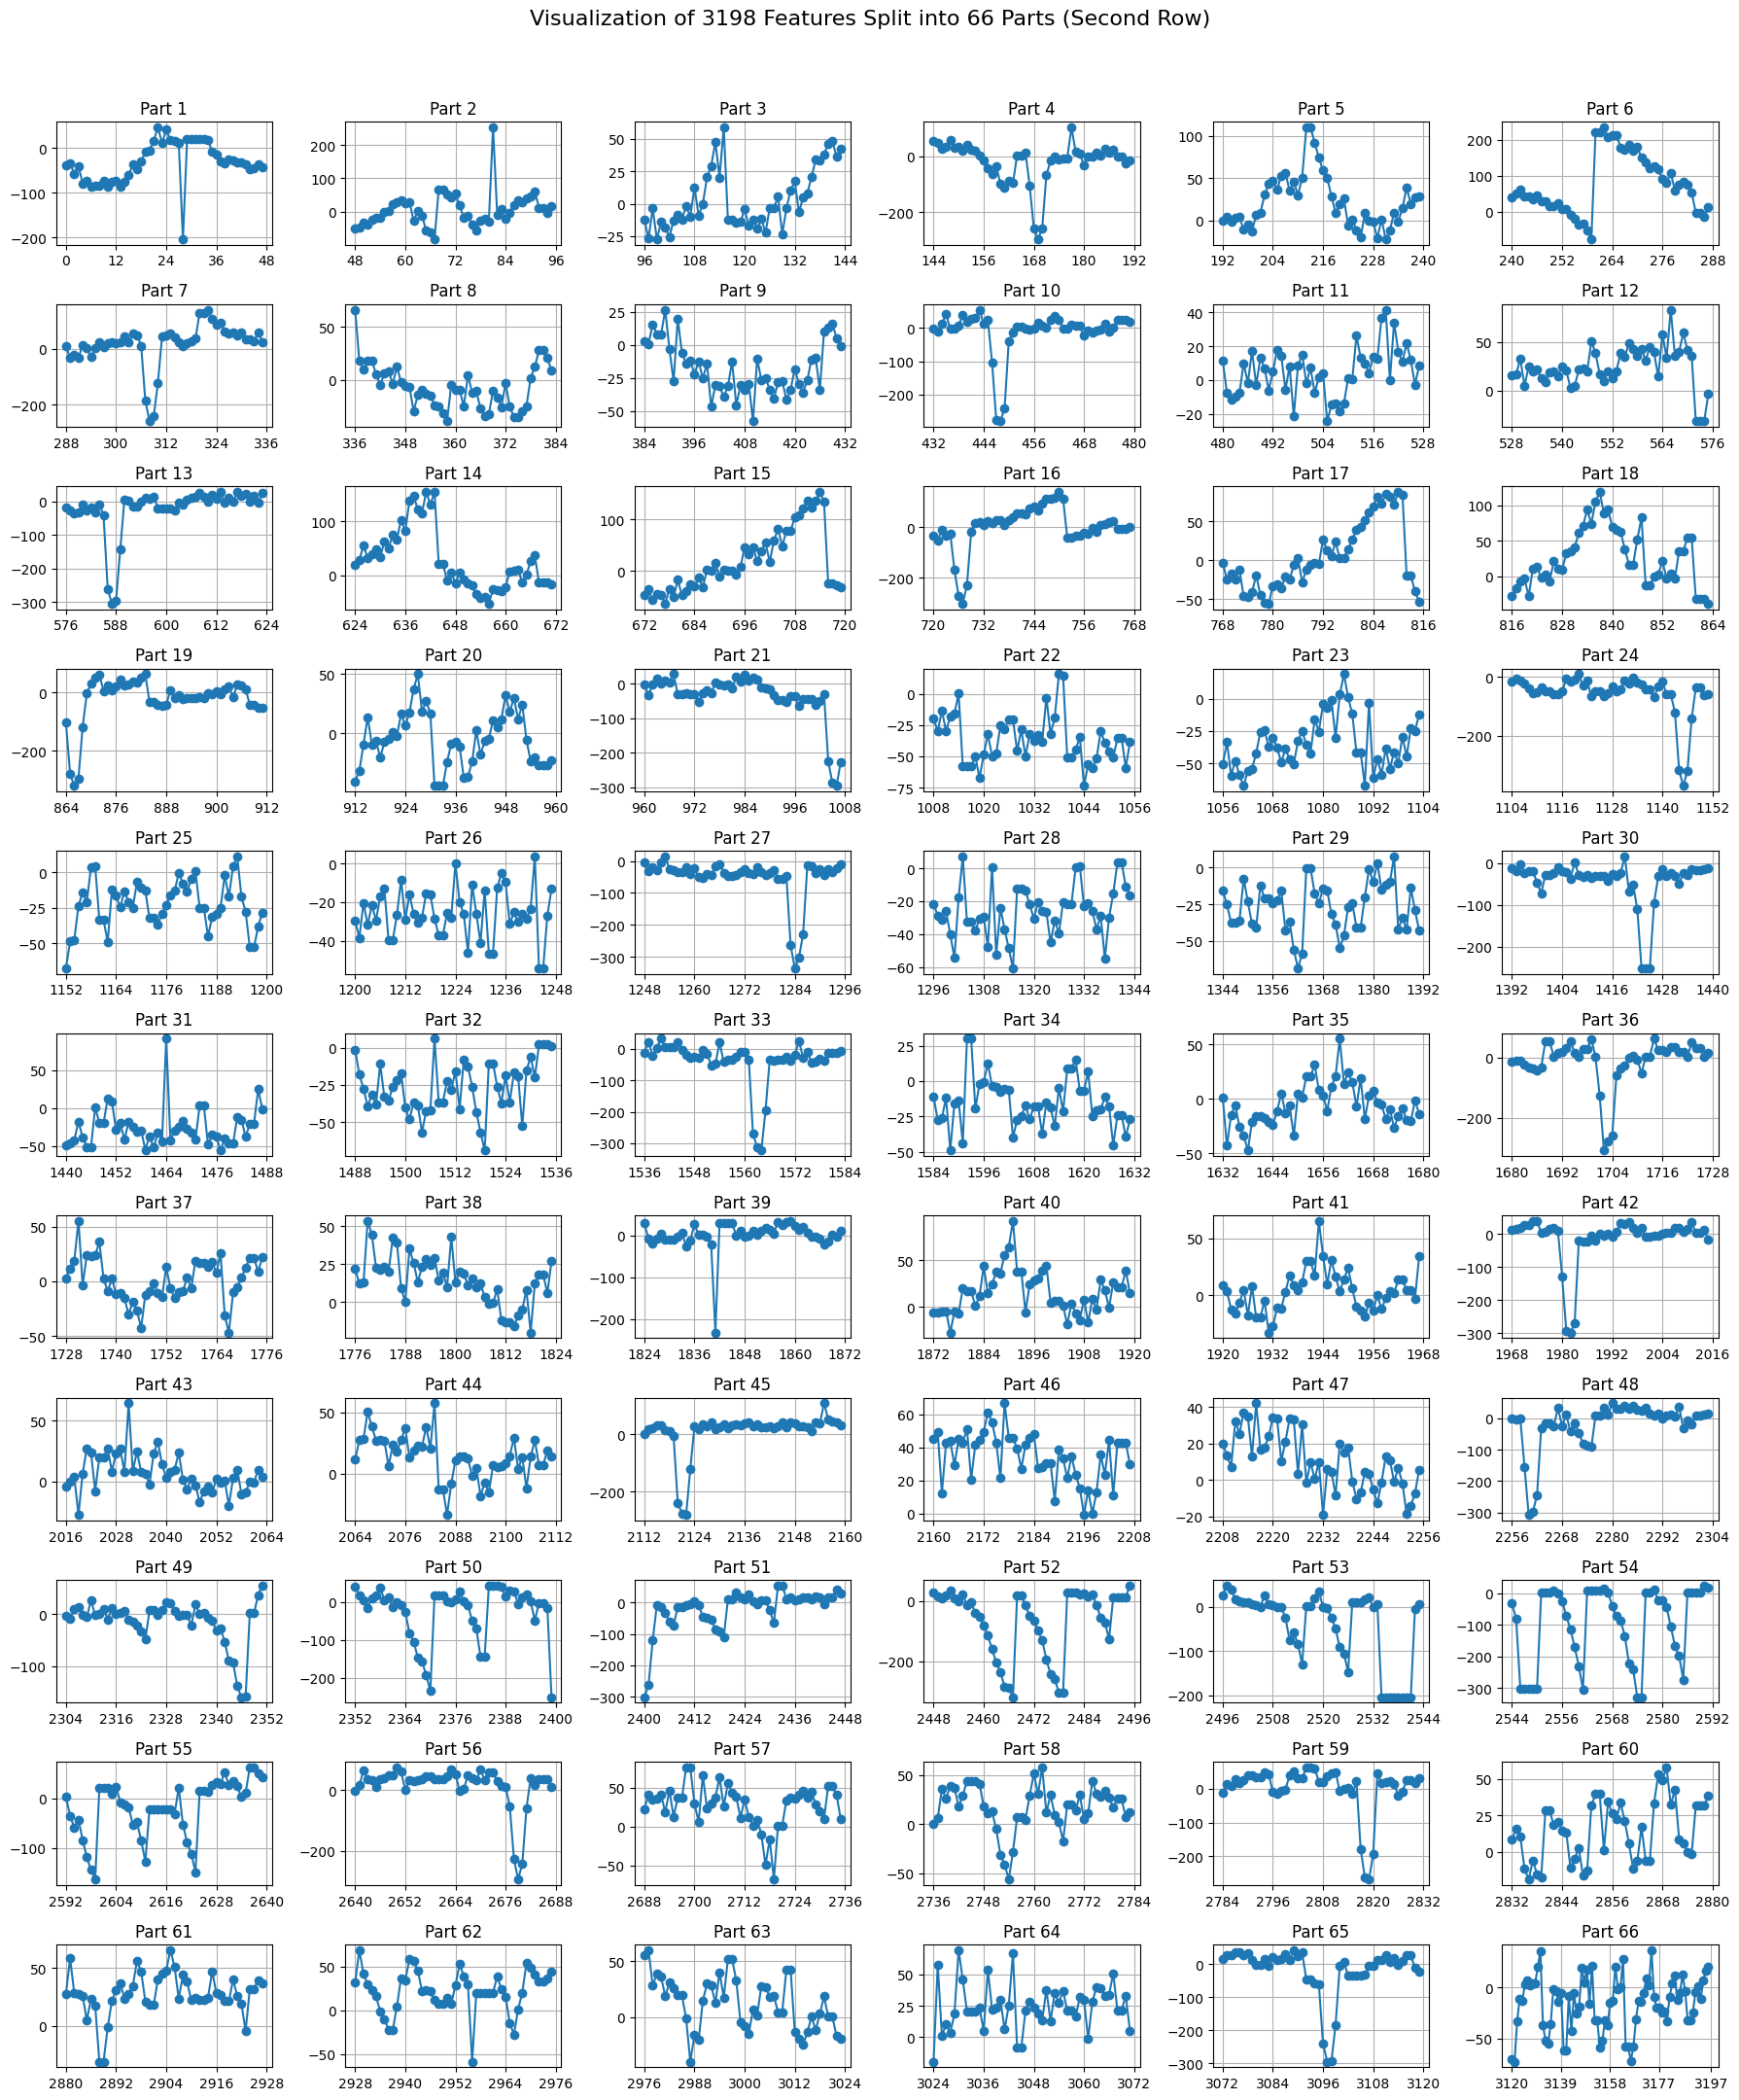

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = "/content/exoTrain.csv"
df = pd.read_csv(file_path)

# Extract the second row (excluding the label column)
features = df.iloc[1, 1:].values

# Split into 66 equal parts
num_splits = 66
split_size = len(features) // num_splits

# Create subplots
fig, axes = plt.subplots(nrows=11, ncols=6, figsize=(18, 22))
fig.suptitle("Visualization of 3198 Features Split into 66 Parts (Second Row)", fontsize=16)

# Plot each part in a separate subplot
for i, ax in enumerate(axes.flat):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < num_splits - 1 else len(features)

    ax.plot(range(start_idx, end_idx), features[start_idx:end_idx], marker='o', linestyle='-')
    ax.set_title(f"Part {i+1}")
    ax.set_xticks(np.linspace(start_idx, end_idx, num=5, dtype=int))
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

###**1. Data Preprocessing & Balancing:**

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_curve, auc
import keras_tuner as kt

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

Merged Dataset - First 5 rows:


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


Merged Dataset - Last 5 rows:


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
5652,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
5653,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
5654,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
5655,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60
5656,1,3071.19,2782.53,2608.69,2325.47,2089.37,1769.56,1421.09,1142.09,902.31,...,695.41,865.97,882.41,1203.06,1293.03,1354.41,-192.81,-277.22,-69.63,121.56


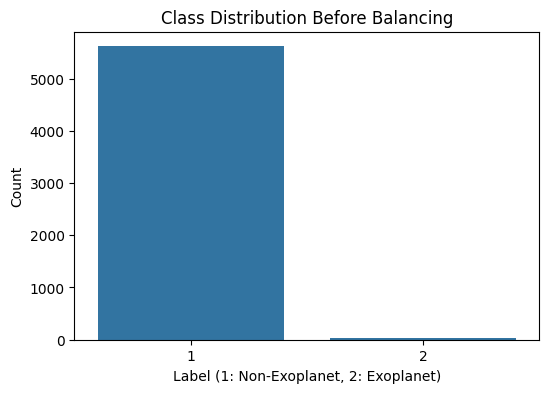

In [ ]:
# Define dataset paths
train_data_path = "exoTrain.csv"
test_data_path = "exoTest.csv"

# Load datasets
exo_train = pd.read_csv(train_data_path)
exo_test = pd.read_csv(test_data_path)

# Merge the datasets
exoplanets = pd.concat([exo_train, exo_test], ignore_index=True)
exoplanets.to_csv("exoplanets.csv", index=False)

# Separate features (flux values) and labels
X = exoplanets.iloc[:, 1:].to_numpy()
y = np.where(exoplanets.iloc[:, 0] == 2, 1, 0)

# Display first and last 5 rows
print("Merged Dataset - First 5 rows:")
display(exoplanets.head())

print("Merged Dataset - Last 5 rows:")
display(exoplanets.tail())

# Visualize class distribution before balancing
plt.figure(figsize=(6, 4))
sns.countplot(x=exoplanets.iloc[:, 0])
plt.title("Class Distribution Before Balancing")
plt.xlabel("Label (1: Non-Exoplanet, 2: Exoplanet)")
plt.ylabel("Count")
plt.show()

Balanced Dataset - First 5 rows:


,Label,0,1,2,3,4,5,6,7,8,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
0,1,-0.002779,-0.004046,-0.004557,-0.007552,-0.006515,-0.007124,-0.005917,-0.007535,-0.007467,...,-0.011207,-0.013617,-0.014495,-0.014887,-0.012864,-0.011324,0.026188,0.030027,0.040030,0.022221
1,0,-0.015144,-0.016523,-0.012903,-0.009842,-0.010352,-0.008912,-0.009073,-0.011883,-0.010706,...,-0.006926,-0.012314,-0.013359,-0.014052,-0.013004,-0.010432,0.031869,0.037989,0.035908,0.026949
2,1,-0.012570,-0.013467,-0.012839,-0.012465,-0.010694,-0.010409,-0.007246,-0.008141,-0.007444,...,-0.010273,-0.013950,-0.014689,-0.014986,-0.013476,-0.012149,0.025452,0.029263,0.025472,0.020986
3,0,-0.008747,-0.008945,-0.008758,-0.009742,-0.008874,-0.008931,-0.006666,-0.008096,-0.007972,...,-0.011593,-0.013952,-0.014661,-0.014736,-0.013110,-0.012209,0.024250,0.028061,0.024183,0.019037
4,1,-0.005454,-0.005582,-0.006291,-0.007634,-0.006126,-0.006672,-0.004794,-0.005929,-0.006480,...,-0.011628,-0.014535,-0.015066,-0.015445,-0.013773,-0.012145,0.024577,0.028582,0.023748,0.019635


Balanced Dataset - Last 5 rows:


,Label,0,1,2,3,4,5,6,7,8,...,3187,3188,3189,3190,3191,3192,3193,3194,3195,3196
11225,1,-0.007939,-0.008283,-0.009996,-0.011629,-0.011531,-0.012942,-0.011373,-0.012024,-0.011869,...,-0.012959,-0.015919,-0.016299,-0.014913,-0.012762,-0.011421,0.024960,0.029697,0.024465,0.017911
11226,0,0.000319,-0.008348,-0.009731,-0.012400,-0.010403,-0.000045,0.007729,0.015762,0.014291,...,-0.053972,-0.068677,-0.068943,-0.064061,-0.060437,-0.047099,-0.119488,-0.116183,-0.146556,-0.185647
11227,0,0.000482,-0.000676,-0.001439,-0.003232,-0.003489,-0.004935,-0.003534,-0.005798,-0.006263,...,-0.011543,-0.013897,-0.014361,-0.014483,-0.012587,-0.011405,0.022353,0.026556,0.021916,0.016179
11228,0,-0.014202,-0.018691,-0.014354,-0.021599,-0.018132,-0.022308,-0.020323,-0.022158,-0.020364,...,-0.010861,-0.013398,-0.014775,-0.015602,-0.010669,-0.006158,0.002321,0.021272,0.012684,0.020248
11229,1,-0.013224,-0.013053,-0.012357,-0.013672,-0.011853,-0.012311,-0.009717,-0.010871,-0.011242,...,-0.022939,-0.023131,-0.021977,-0.020838,-0.019371,-0.018267,0.006311,0.008914,0.004052,-0.004480


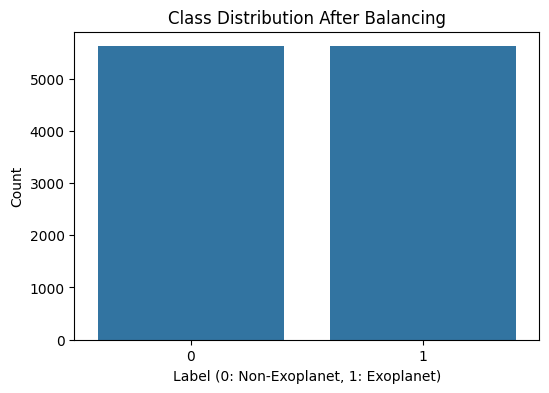

In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "exoplanets_scaler.pkl")

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Shuffle dataset to ensure randomness
shuffled_indices = np.random.permutation(len(X_resampled))
X_resampled, y_resampled = X_resampled[shuffled_indices], y_resampled[shuffled_indices]

# Save balanced dataset
balanced_data = pd.DataFrame(X_resampled)
balanced_data.insert(0, "Label", y_resampled)
balanced_data.to_csv("exoplanets_balanced.csv", index=False)

# Display first and last 5 rows of the balanced dataset
print("Balanced Dataset - First 5 rows:")
display(balanced_data.head())

print("Balanced Dataset - Last 5 rows:")
display(balanced_data.tail())

# Visualize class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title("Class Distribution After Balancing")
plt.xlabel("Label (0: Non-Exoplanet, 1: Exoplanet)")
plt.ylabel("Count")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Split the dataset into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=SEED, stratify=y_resampled, shuffle=True
)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

###**2. Feature Engineering:**

In [ ]:
def create_sliding_windows(data, window_size=30, overlap=10):
    """
    Creates overlapping sliding windows for time-series data.

    Parameters:
    - data: (num_samples, num_features) numpy array
    - window_size: Number of time steps in each window
    - overlap: Overlap between consecutive windows

    Returns:
    - Reshaped numpy array of shape (num_samples, num_windows, window_size)
    """
    num_samples, num_features = data.shape
    step_size = window_size - overlap
    num_windows = (num_features - overlap) // step_size

    windows = np.zeros((num_samples, num_windows, window_size))

    for i in range(num_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_size
        if end_idx <= num_features:
            windows[:, i, :] = data[:, start_idx:end_idx]

    return windows

# Define sliding window parameters
WINDOW_SIZE = 30
OVERLAP = 10

# Apply sliding window transformation to training and validation sets
X_train = create_sliding_windows(X_train, window_size=WINDOW_SIZE, overlap=OVERLAP)
X_val = create_sliding_windows(X_val, window_size=WINDOW_SIZE, overlap=OVERLAP)

###**3. Model Building & Hyperparameter Tuning:**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

def build_model(hp):
    """
    Builds an LSTM-based deep learning model with hyperparameter tuning.

    Parameters:
    - hp: Hyperparameter tuner object

    Returns:
    - Compiled LSTM model
    """
    model = keras.Sequential([
        layers.LSTM(hp.Choice('units', [64, 128, 256]), activation='tanh', return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2])),
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.4])),

        layers.LSTM(hp.Choice('units', [64, 128, 256]), activation='tanh', return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.4])),

        layers.LSTM(hp.Choice('units', [32, 64, 128]), activation='tanh', return_sequences=False),
        layers.BatchNormalization(),
        layers.Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.4])),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.0001, 0.001, 0.01])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Initialize hyperparameter tuning using Random Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='exoplanet_lstm'
)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

Trial 5 Complete [00h 01m 14s]
val_accuracy: 0.8900266885757446

Best val_accuracy So Far: 0.9016028642654419
Total elapsed time: 00h 06m 14s


###**4. Model Training & Evaluation:**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define batch size
BATCH_SIZE = 32

# Train the best model with early stopping and learning rate reduction
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
    ]
)

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5598 - loss: 0.8324 - val_accuracy: 0.5450 - val_loss: 0.7523 - learning_rate: 1.0000e-04
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7081 - loss: 0.6125 - val_accuracy: 0.5770 - val_loss: 2.3762 - learning_rate: 1.0000e-04
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7879 - loss: 0.4902 - val_accuracy: 0.5712 - val_loss: 4.6299 - learning_rate: 1.0000e-04
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8329 - loss: 0.3912 - val_accuracy: 0.7484 - val_loss: 0.7559 - learning_rate: 5.0000e-05
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8522 - loss: 0.3385 - val_accuracy: 0.7035 - val_loss: 1.3997 - learning_rate: 5.0000e-05
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8809 - loss: 0.2928 - val_accuracy: 0.8366 - val_loss: 0.4255 - learning_rate: 2.5000e-05
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - ac

###**5. Performance Metrics & Visualizations:**

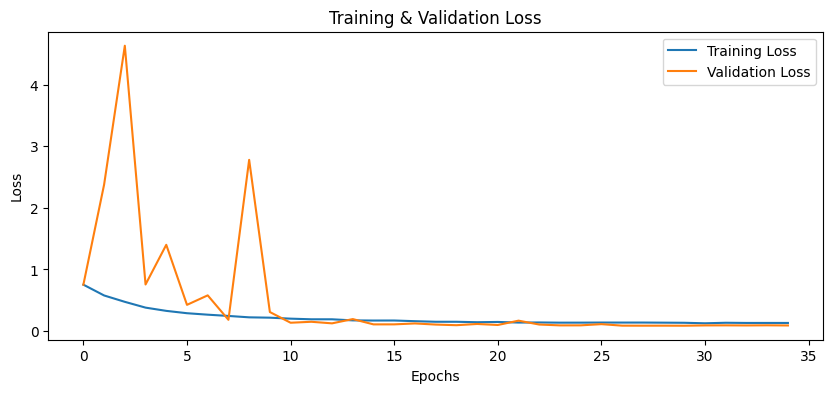

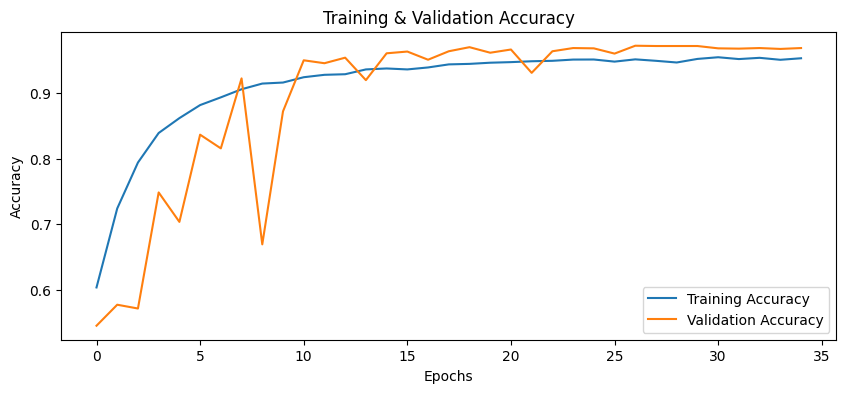

In [ ]:
# Extract training history
history_dict = history.history

# Plot Training & Validation Loss
plt.figure(figsize=(10, 4))
plt.plot(history_dict['loss'], label="Training Loss")
plt.plot(history_dict['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history_dict['accuracy'], label="Training Accuracy")
plt.plot(history_dict['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# Compute final training & validation accuracy
train_acc = history_dict["accuracy"][-1]
val_acc = history_dict["val_accuracy"][-1]

# Compute the difference
acc_diff = train_acc - val_acc

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Accuracy Difference (Train - Validation): {acc_diff:.4f}")

# If accuracy difference > 0.05, model might be overfitting
if acc_diff > 0.05:
    print("Possible Overfitting Detected!")
else:
    print("✅ Model shows no significant overfitting.")

Final Training Accuracy: 0.9533
Final Validation Accuracy: 0.9688
Accuracy Difference (Train - Validation): -0.0156
✅ Model shows no significant overfitting.


In [ ]:
from sklearn.metrics import classification_report

# Make predictions
y_val_pred_prob = best_model.predict(X_val)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Non-Exoplanet (0)", "Exoplanet (1)"]))

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:
                   precision    recall  f1-score   support

Non-Exoplanet (0)       1.00      0.94      0.97      1123
    Exoplanet (1)       0.95      1.00      0.97      1123

         accuracy                           0.97      2246
        macro avg       0.97      0.97      0.97      2246
     weighted avg       0.97      0.97      0.97      2246



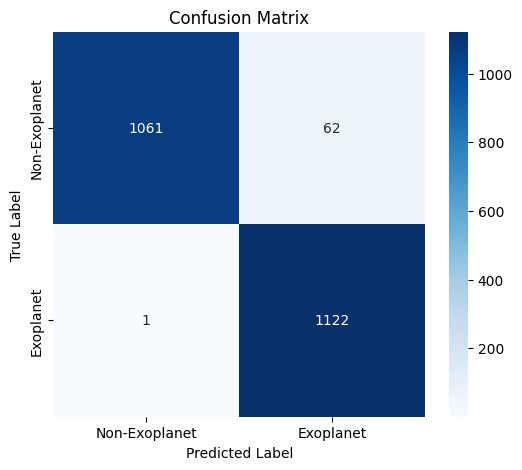

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Exoplanet", "Exoplanet"],
            yticklabels=["Non-Exoplanet", "Exoplanet"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

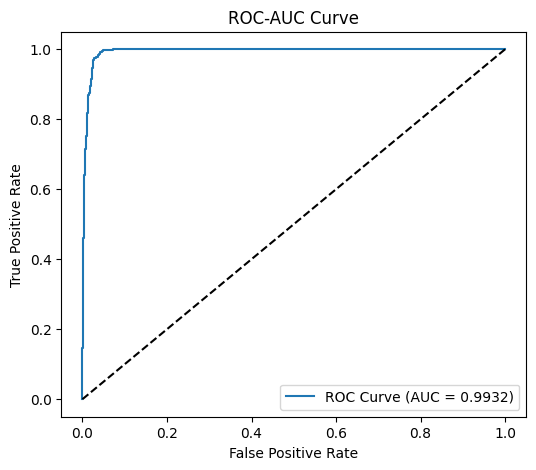

ROC-AUC Score: 0.9932


In [ ]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")